In [574]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Library untuk analisis time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# library untuk Forecasting
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

## LoadDataset

In [575]:
data = pd.read_csv('AirQualityUCI.csv', delimiter=";")
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


# Pre-processing


In [576]:
# Menggabungkan kolom 'Date' dan 'Time' menjadi 'Datetime'
data["Datetime"] = pd.to_datetime(data["Date"] + " " + data["Time"], format="%d/%m/%Y %H.%M.%S")

# Menghapus kolom yang tidak relevan
data.drop(columns=["Date", "Time", "Unnamed: 15", "Unnamed: 16"], inplace=True)

# Membersihkan kolom numerik: menghapus spasi dan mengganti koma/titik dengan format float
for col in data.columns:
    data[col] = data[col].astype(str).str.replace(r"[^\d.-]", "", regex=True).replace("", pd.NA)
    if col != "Datetime":
        data[col] = pd.to_numeric(data[col], errors="coerce")

# Menampilkan hasil awal setelah pembersihan
data

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
0,26.0,1360.0,150.0,119.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,136.0,489.0,7578.0,2004-03-10180000
1,2.0,1292.0,112.0,94.0,955.0,103.0,1174.0,92.0,1559.0,972.0,133.0,477.0,7255.0,2004-03-10190000
2,22.0,1402.0,88.0,90.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,119.0,540.0,7502.0,2004-03-10200000
3,22.0,1376.0,80.0,92.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,110.0,600.0,7867.0,2004-03-10210000
4,16.0,1272.0,51.0,65.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,112.0,596.0,7888.0,2004-03-10220000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>


In [577]:
data_cleaned = data.dropna()
data_cleaned

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
0,26.0,1360.0,150.0,119.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,136.0,489.0,7578.0,2004-03-10180000
1,2.0,1292.0,112.0,94.0,955.0,103.0,1174.0,92.0,1559.0,972.0,133.0,477.0,7255.0,2004-03-10190000
2,22.0,1402.0,88.0,90.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,119.0,540.0,7502.0,2004-03-10200000
3,22.0,1376.0,80.0,92.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,110.0,600.0,7867.0,2004-03-10210000
4,16.0,1272.0,51.0,65.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,112.0,596.0,7888.0,2004-03-10220000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,31.0,1314.0,-200.0,135.0,1101.0,472.0,539.0,190.0,1374.0,1729.0,219.0,293.0,7568.0,2005-04-04100000
9353,24.0,1163.0,-200.0,114.0,1027.0,353.0,604.0,179.0,1264.0,1269.0,243.0,237.0,7119.0,2005-04-04110000
9354,24.0,1142.0,-200.0,124.0,1063.0,293.0,603.0,175.0,1241.0,1092.0,269.0,183.0,6406.0,2005-04-04120000
9355,21.0,1003.0,-200.0,95.0,961.0,235.0,702.0,156.0,1041.0,770.0,283.0,135.0,5139.0,2005-04-04130000


In [578]:
data_cleaned.shape

(9357, 14)

In [579]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   float64
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
 13  Datetime       9357 non-null   object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [580]:
data_cleaned.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-36.996687,1048.990061,-159.090093,18.656834,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,168.190232,465.260981,9846.342524
std,211.793927,329.832710,139.789093,413.802064,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,114.081191,216.407635,4447.196714
min,-2000.000000,-200.000000,-200.000000,-2000.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,4.000000,921.000000,-200.000000,40.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,109.000000,341.000000,6923.000000
50%,14.000000,1053.000000,-200.000000,79.000000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,172.000000,486.000000,9768.000000
75%,25.000000,1221.000000,-200.000000,136.000000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,241.000000,619.000000,12962.000000
max,119.000000,2040.000000,1189.000000,637.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,446.000000,887.000000,22310.000000


In [581]:
print(data_cleaned['CO(GT)'].describe())
print(data_cleaned['CO(GT)'].min())

count    9357.000000
mean      -36.996687
std       211.793927
min     -2000.000000
25%         4.000000
50%        14.000000
75%        25.000000
max       119.000000
Name: CO(GT), dtype: float64
-2000.0


In [582]:
# Hilangkan nilai negatif
data_cleaned = data_cleaned[data_cleaned['CO(GT)'] > 0]

# Hitung ulang rata-rata
mean_co = data_cleaned['CO(GT)'].mean()
print(f"Rata-rata nilai CO(GT) setelah perbaikan: {mean_co}")


Rata-rata nilai CO(GT) setelah perbaikan: 20.09669012249153


In [583]:
# Gunakan data asli sebelum differencing
mean_original = data_cleaned['CO(GT)'].mean()
print(f"Rata-rata nilai asli CO(GT): {mean_original}")

Rata-rata nilai asli CO(GT): 20.09669012249153


In [584]:
# Cek missing values
print(data_cleaned.isnull().sum())

CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Datetime         0
dtype: int64


In [585]:
# Hilangkan semua data kecuali Datetime dan CO(GT)
data_cleaned = data_cleaned[['Datetime', 'CO(GT)']]

In [586]:
data_cleaned.head()

,Datetime,CO(GT)
0,2004-03-10180000,26.0
1,2004-03-10190000,2.0
2,2004-03-10200000,22.0
3,2004-03-10210000,22.0
4,2004-03-10220000,16.0


In [587]:
# Menyimpan dataset yang sudah dibersihkan ke file CSV
file_name = 'cleaned_dataset.csv'
data_cleaned.to_csv(file_name, index=False)

## Transform Data

In [588]:
data_cleaned['Datetime'] = pd.to_datetime(data_cleaned['Datetime'], format='%Y-%m-%d%H%M%S')

print(data_cleaned.head())

             Datetime  CO(GT)
0 2004-03-10 18:00:00    26.0
1 2004-03-10 19:00:00     2.0
2 2004-03-10 20:00:00    22.0
3 2004-03-10 21:00:00    22.0
4 2004-03-10 22:00:00    16.0


In [589]:
# Set Datetime sebagai index
data_cleaned.set_index('Datetime', inplace=True)

# Tampilkan hasil
data_cleaned.head()

,CO(GT)
Datetime,
2004-03-10 18:00:00,26.0
2004-03-10 19:00:00,2.0
2004-03-10 20:00:00,22.0
2004-03-10 21:00:00,22.0
2004-03-10 22:00:00,16.0


In [590]:
data_cleaned.index.min(), data_cleaned.index.max()

(Timestamp('2004-03-10 18:00:00'), Timestamp('2005-04-04 14:00:00'))

In [591]:
if(data_cleaned.index.max() - data_cleaned.index.min() == 214):
    print('Data continue')

In [592]:
data_cleaned.index = pd.to_datetime(data_cleaned.index)

In [593]:
print(data_cleaned.index.dtype)

datetime64[ns]


In [594]:
data_cleaned = data_cleaned.asfreq('h')

In [595]:
data_cleaned = data_cleaned.asfreq('h').ffill()  # Isi data yang hilang dengan nilai sebelumnya

In [596]:
print(data_cleaned.index.freq)

<Hour>


## Analisa Time Series

<Axes: xlabel='Datetime'>

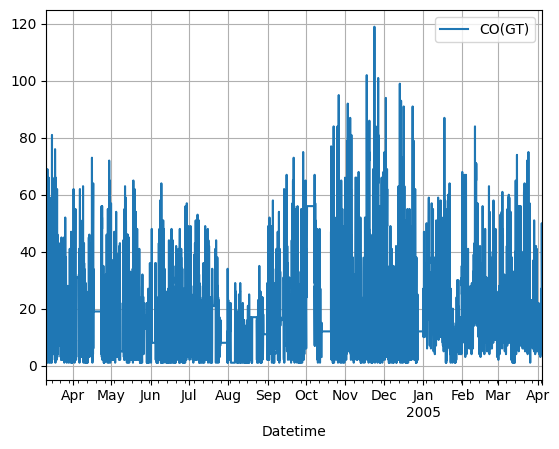

In [597]:
data_cleaned.plot(grid=True)

In [676]:
# Menghitung titik 70% dari jumlah baris data
train_size = int(len(data_cleaned) * 0.7)

# Membagi data menjadi dua bagian (70% untuk training dan 30% untuk testing)
train_data = data_cleaned.iloc[:train_size]
test_data = data_cleaned.iloc[train_size:]

In [677]:
train_data

,CO(GT),Month
Datetime,,
2004-03-10 18:00:00,26.0,3
2004-03-10 19:00:00,2.0,3
2004-03-10 20:00:00,22.0,3
2004-03-10 21:00:00,22.0,3
2004-03-10 22:00:00,16.0,3
...,...,...
2004-12-08 10:00:00,17.0,12
2004-12-08 11:00:00,23.0,12
2004-12-08 12:00:00,21.0,12


In [678]:
test_data

,CO(GT),Month
Datetime,,
2004-12-08 15:00:00,12.0,12
2004-12-08 16:00:00,14.0,12
2004-12-08 17:00:00,19.0,12
2004-12-08 18:00:00,26.0,12
2004-12-08 19:00:00,24.0,12
...,...,...
2005-04-04 10:00:00,31.0,4
2005-04-04 11:00:00,24.0,4
2005-04-04 12:00:00,24.0,4


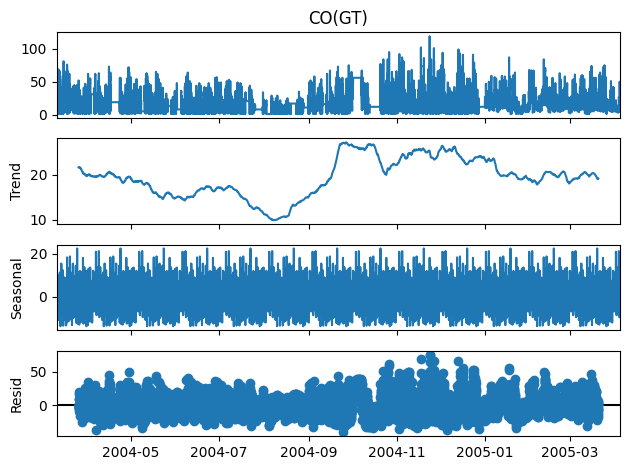

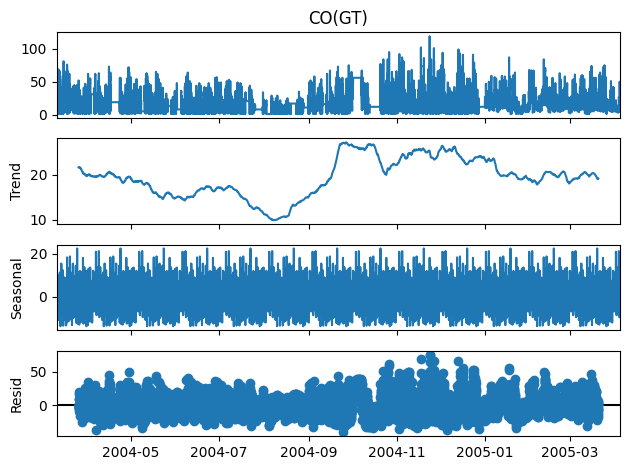

In [688]:
decompose_add = seasonal_decompose(data_cleaned['CO(GT)'], period=720)  
decompose_add.plot()

In [689]:
# data_cleaned['Month'] = data_cleaned.index.month
# monthly_avg = data_cleaned.groupby('Month')['CO(GT)'].mean()
# monthly_avg.plot(kind='bar')

Stationarity Check


Hasil testing....
-----------------------
Test statistic              -9.301315e+00
p-value                      1.110533e-15
Lags Used                    2.900000e+01
Number of Observation use    9.327000e+03
Critical Value (1%)         -3.431051e+00
Critical Value (5%)         -2.861850e+00
Critical Value (10%)        -2.566935e+00
dtype: float64


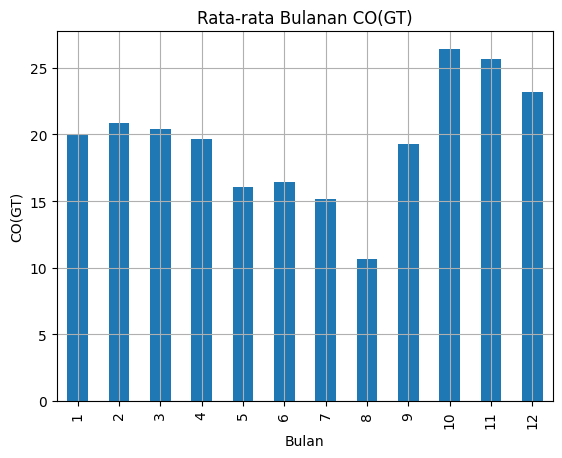

In [690]:
from statsmodels.tsa.stattools import adfuller

# Uji stasioneritas dengan ADF
def adf_test(timeseries):
    print("Hasil testing....")
    print("-----------------------")
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test statistic', 'p-value', 'Lags Used', 'Number of Observation use'])
    for key, Value in adftest[4].items() :
        adf_output['Critical Value (%s)' %key] = Value
    print(adf_output)


# adf_test(data_cleaned.values)      
# Uji ADF hanya pada kolom 'CO(GT)'
adf_test(data_cleaned['CO(GT)'])

# Tambahkan kolom 'Month'
data_cleaned['Month'] = data_cleaned.index.month

# Hitung rata-rata bulanan
monthly_avg = data_cleaned.groupby('Month')['CO(GT)'].mean()

# Plot rata-rata bulanan
monthly_avg.plot(kind='bar')
plt.title('Rata-rata Bulanan CO(GT)')
plt.ylabel('CO(GT)')
plt.xlabel('Bulan')
plt.grid(True)
plt.show()

In [691]:
diff_data = data_cleaned['CO(GT)'].diff()
diff_data.head()

Datetime
2004-03-10 18:00:00     NaN
2004-03-10 19:00:00   -24.0
2004-03-10 20:00:00    20.0
2004-03-10 21:00:00     0.0
2004-03-10 22:00:00    -6.0
Freq: h, Name: CO(GT), dtype: float64

In [692]:
diff_data.dropna(inplace=True)

<Axes: xlabel='Datetime'>

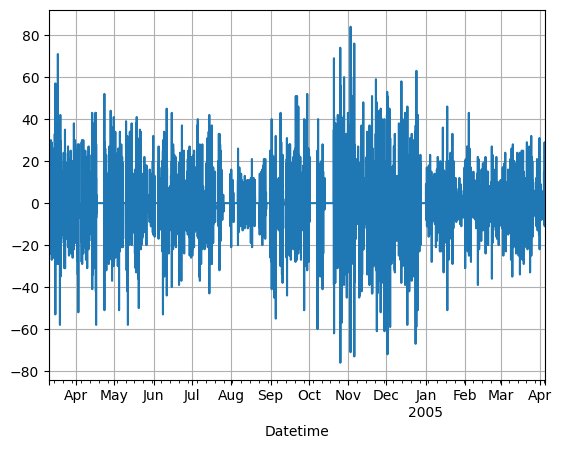

In [693]:
diff_data.plot(grid=True)

In [694]:
adf_test(diff_data)

Hasil testing....
-----------------------
Test statistic                -25.963075
p-value                         0.000000
Lags Used                      27.000000
Number of Observation use    9328.000000
Critical Value (1%)            -3.431051
Critical Value (5%)            -2.861850
Critical Value (10%)           -2.566935
dtype: float64


Gunakan plot ACF dan PACF untuk menentukan parameter ARIMA.

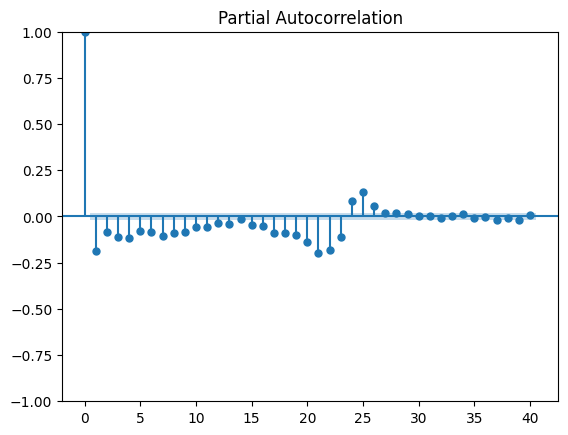

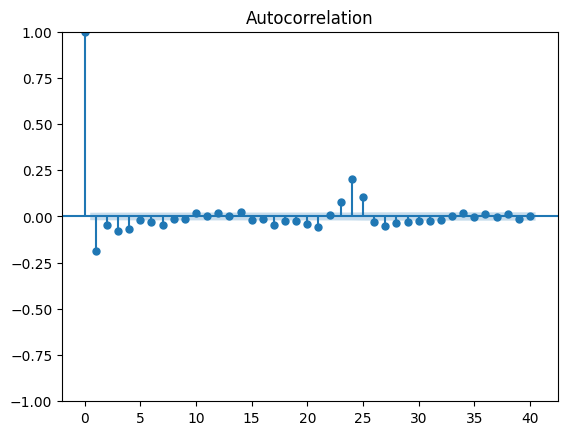

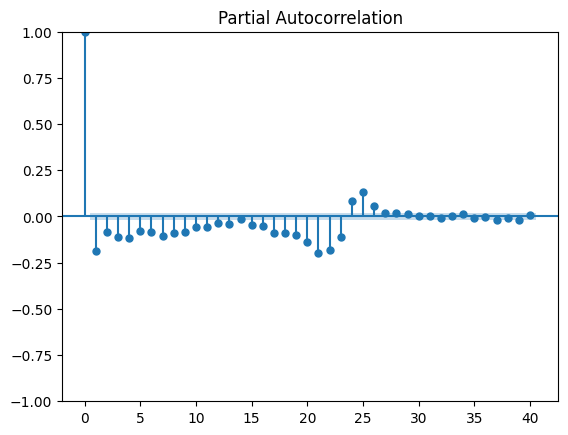

In [695]:
plot_acf(diff_data)
plot_pacf(diff_data)

# Modeling ARIMA


In [699]:
ar = ARIMA(train_data['CO(GT)'], order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(30)

D:\DataMining\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


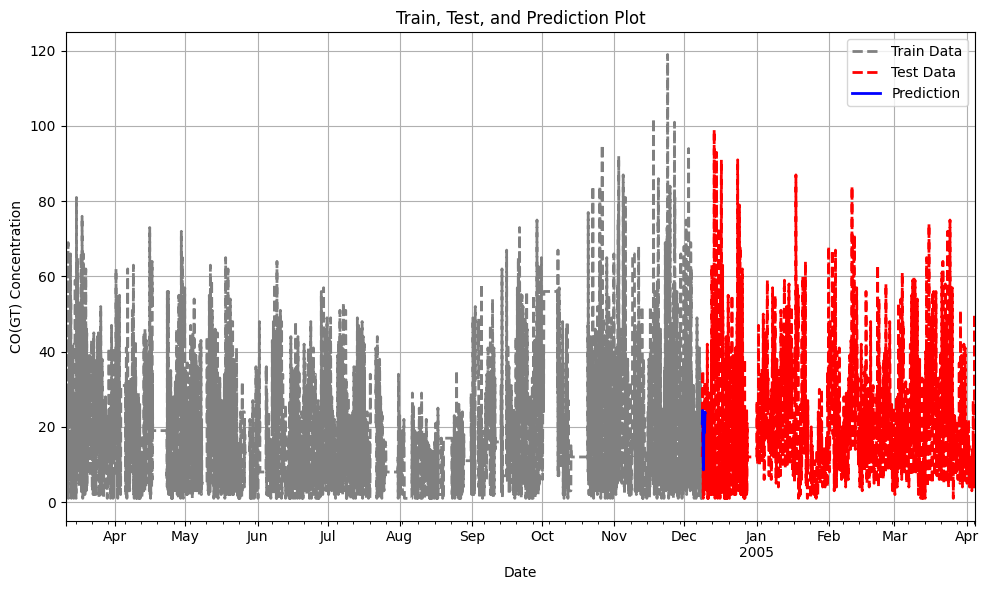

In [701]:
plt.figure(figsize=(10, 6))  # Menyesuaikan ukuran plot

# Plot data train, test, dan prediksi
train_data['CO(GT)'].plot(style='--', color='gray', label='Train Data', linewidth=2)
test_data['CO(GT)'].plot(style='--', color='red', label='Test Data', linewidth=2)
ar_test_pred.plot(color='blue', label='Prediction', linewidth=2)

# Menambahkan judul dan label
plt.title('Train, Test, and Prediction Plot')
plt.xlabel('Date')
plt.ylabel('CO(GT) Concentration')

# Menambahkan legenda
plt.legend()

# Menampilkan plot
plt.grid(True)
plt.tight_layout()  # Menyesuaikan layout agar tidak terpotong
plt.show()

In [702]:
# Pilih hanya 30 data terakhir dari test_data untuk menghitung error
test_data_relevant = test_data.iloc[:len(ar_test_pred)]

# Hitung RMSE dan MAPE hanya untuk data yang relevan
print('Train RMSE:', mean_squared_error(train_data['CO(GT)'], ar_train_pred) ** 0.5)
print('Test RMSE:', mean_squared_error(test_data_relevant['CO(GT)'], ar_test_pred) ** 0.5)

print('Train MAPE:', mean_absolute_percentage_error(train_data['CO(GT)'], ar_train_pred))
print('Test MAPE:', mean_absolute_percentage_error(test_data_relevant['CO(GT)'], ar_test_pred))


Train RMSE: 9.637826117361193
Test RMSE: 7.04258355156679
Train MAPE: 0.9930595847785537
Test MAPE: 1.1291374602187192


## Modeling Single Exp Smoothing

In [704]:
single_exp = SimpleExpSmoothing(train_data['CO(GT)']).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(30)

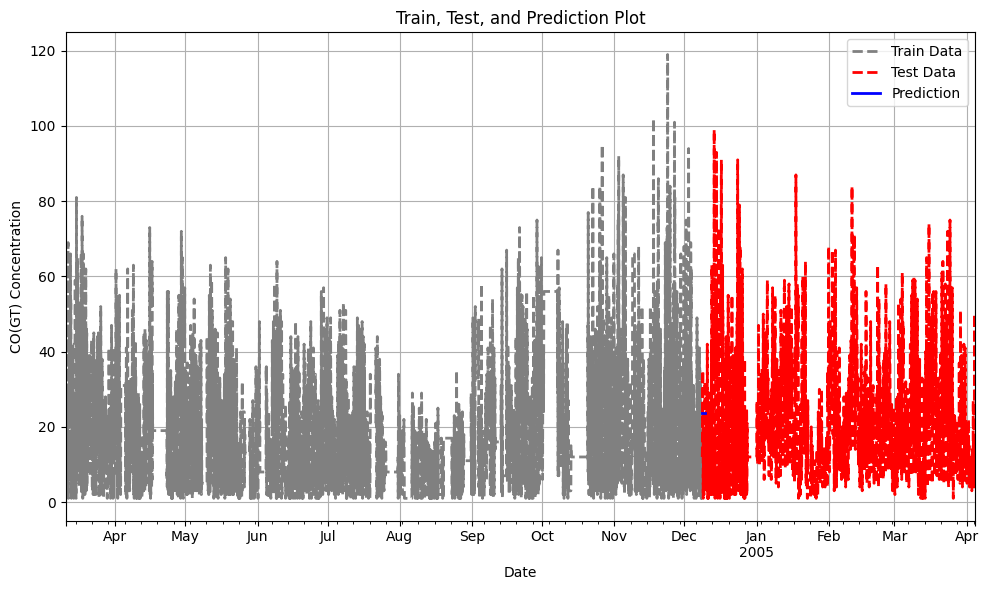

In [705]:
plt.figure(figsize=(10, 6))  # Menyesuaikan ukuran plot

# Plot data train, test, dan prediksi
train_data['CO(GT)'].plot(style='--', color='gray', label='Train Data', linewidth=2)
test_data['CO(GT)'].plot(style='--', color='red', label='Test Data', linewidth=2)
single_exp_test_pred.plot(color='blue', label='Prediction', linewidth=2)

# Menambahkan judul dan label
plt.title('Train, Test, and Prediction Plot')
plt.xlabel('Date')
plt.ylabel('CO(GT) Concentration')

# Menambahkan legenda
plt.legend()

# Menampilkan plot
plt.grid(True)
plt.tight_layout()  # Menyesuaikan layout agar tidak terpotong
plt.show()

In [706]:
# Pilih hanya 30 data terakhir dari test_data untuk menghitung error
test_data_relevant = test_data.iloc[:len(single_exp_test_pred)]

# Hitung RMSE dan MAPE hanya untuk data yang relevan
print('Train RMSE:', mean_squared_error(train_data['CO(GT)'], single_exp_train_pred) ** 0.5)
print('Test RMSE:', mean_squared_error(test_data_relevant['CO(GT)'], single_exp_test_pred) ** 0.5)

print('Train MAPE:', mean_absolute_percentage_error(train_data['CO(GT)'], single_exp_train_pred))
print('Test MAPE:', mean_absolute_percentage_error(test_data_relevant['CO(GT)'], single_exp_test_pred))

Train RMSE: 10.681915142656802
Test RMSE: 11.843791010897753
Train MAPE: 0.9182433706777955
Test MAPE: 2.155014029187566


## Modeling Double Exp Smoothing

In [707]:
double_exp = ExponentialSmoothing(train_data['CO(GT)'], trend=None, initialization_method='estimated', seasonal=None, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(30)

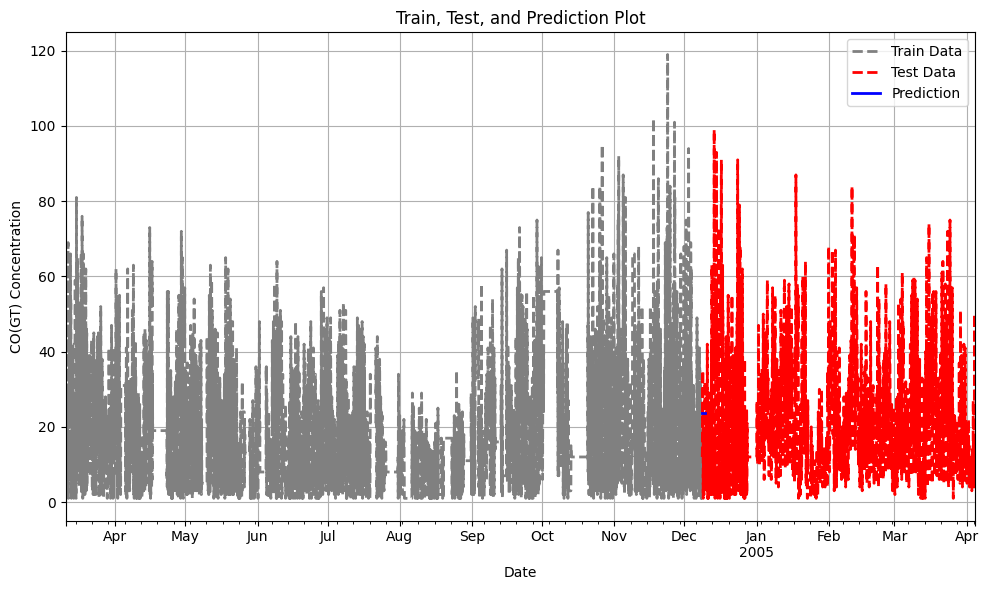

In [708]:
plt.figure(figsize=(10, 6))  # Menyesuaikan ukuran plot

# Plot data train, test, dan prediksi
train_data['CO(GT)'].plot(style='--', color='gray', label='Train Data', linewidth=2)
test_data['CO(GT)'].plot(style='--', color='red', label='Test Data', linewidth=2)
double_exp_test_pred.plot(color='blue', label='Prediction', linewidth=2)

# Menambahkan judul dan label
plt.title('Train, Test, and Prediction Plot')
plt.xlabel('Date')
plt.ylabel('CO(GT) Concentration')

# Menambahkan legenda
plt.legend()

# Menampilkan plot
plt.grid(True)
plt.tight_layout()  # Menyesuaikan layout agar tidak terpotong
plt.show()

In [709]:
# Pilih hanya 30 data terakhir dari test_data untuk menghitung error
test_data_relevant = test_data.iloc[:len(double_exp_test_pred)]

# Hitung RMSE dan MAPE hanya untuk data yang relevan
print('Train RMSE:', mean_squared_error(train_data['CO(GT)'], double_exp_train_pred) ** 0.5)
print('Test RMSE:', mean_squared_error(test_data_relevant['CO(GT)'], double_exp_test_pred) ** 0.5)

print('Train MAPE:', mean_absolute_percentage_error(train_data['CO(GT)'], double_exp_train_pred))
print('Test MAPE:', mean_absolute_percentage_error(test_data_relevant['CO(GT)'], double_exp_test_pred))

Train RMSE: 10.681656740576223
Test RMSE: 11.843743487603282
Train MAPE: 0.9181801685960458
Test MAPE: 2.1550051307537617


# Evaluasi MAPE dan RMSE

## Perbandingan Algoritma

In [710]:
comparision_data = pd.DataFrame(data=[
    ['Single Exp Smoothing', 11.8437, 2.1550],
    ['Double Exp Smoothing', 11.8437, 2.1550],
    ['ARIMA', 7.0425, 1.1291]
    ],
        columns=['Model', 'RMSE', 'MAPE'])
comparision_data.set_index('Model', inplace=True)

In [711]:
comparision_data.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
ARIMA,7.0425,1.1291
Single Exp Smoothing,11.8437,2.1550
Double Exp Smoothing,11.8437,2.1550


In [712]:
ar = ARIMA(data_cleaned['CO(GT)'], order=(15,1,15)).fit()
ar_pred = ar.forecast(10)

D:\DataMining\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


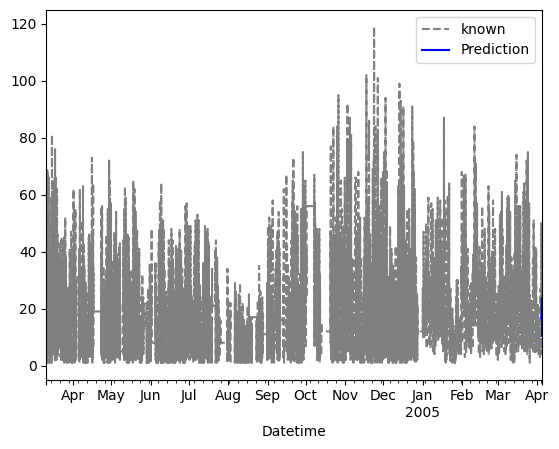

In [713]:
data_cleaned['CO(GT)'].plot(style='--', color='gray', label='known', legend=True)
ar_pred.plot(color='blue', label='Prediction', legend=True)
plt.show()

In [714]:
import pickle
pickle.dump(ar, open('model_predict_CO(GT).sav', 'wb'))